# Proyecto de Tensorflow + Keras para Machine Learning y Neural Networks

### Introducción

El advenimiento de la inteligencia artificial está cambiando al mundo a pasos agigantados. Así que hoy vamos a hacer un pequeño proyecto introductorio utilizando Tensorflow y Keras para hacer crear un modelo que utiliza una red neural para poder reconocer imágenes. 

### Concepto

En el ámbito de Deep Learning, Convoluted Neural Networks (CNN) son un tipo de Artificial Neural Networks (ANN) que se utilizan principalmente para el reconocimiento de imágenes. La arquitectura y procesamiento del imput en esta red es particularmente bueno con imágenes y otros imputs con topografía de tipo grilla, ya que la convolución y el pooling toman en cuenta las relaciones espaciales que existen en el tensor de entrada. 

Suponinedo que tenemos un set de imágenes que queremos clasificar de manera binaria podemos entrenar una CNN para reconocer y clasificar este set con un nivel alto de exactitud. Para eso utilizaremos Tensorflow y Keras para hacerlo. 

Tensorflow es una Machine Learning Platform desarrollada por Google, y funciona también como una open-source library para Machine Learnind y AI. Keras es una NN API que, si bien comenzó de manera independiente, eventualmente fue integrada completamente con Tensorflow.

Utilizando estas herramientas lograremos armar un modelo apto, entrenarlo, validarlo y testearlo para el reconocimiento y la clasificación de imágenes.

### Organizando y preparando data 

Para nuestro proyecto hemos decidido contar con un set de imágenes de perros y gatos, para poder entrenar a nuestra CNN en como identificar perros o gatos en las fotos y clasificarlos sobre esa identificación. Para eso contaremos con un subset random de el data set Kaggle Dogs versus Cats competition. 

La parte más importante de todo el campo de Data Analysis es el procesamiento previo de la información con la que contamos. Limpiar, organizar y moldear data es un paso previo fundamental antes de empezar con cualquier tipo de código. Así que eso es lo que vamos a hacer primero.

Primero descargamos y organizamos el dataset dentro de los directorios que corresponden. Este data set contiene la información de las etiquetas en el nombre de cada muestra. 

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vicferdez","key":"e71b48808e859f3f8ceeb01a24823ac1"}'}

In [4]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle competitions download -c 'dogs-vs-cats'



 98% 795M/812M [00:04<00:00, 226MB/s]
100% 812M/812M [00:04<00:00, 205MB/s]


In [7]:
!mkdir data

In [8]:
!unzip dogs-vs-cats.zip -d data

Archive:  dogs-vs-cats.zip
  inflating: data/sampleSubmission.csv  
  inflating: data/test1.zip          
  inflating: data/train.zip          


In [13]:
!cd data

In [ ]:
!unzip data/train.zip -d data/

Una vez armados nuestros directorios con las muestras correspondientes, podemos importar las herramientas que vamos a utilizar.

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

Ahora organizamos nuestra data dentro de directorios para entrenamiento, validación y testeo. Luego seteamos variables para cada uno de estos directorios. 

In [19]:
os.chdir('data/train')
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')

    for i in random.sample(glob.glob('cat*'), 500):
        shutil.move(i, 'train/cat')      
    for i in random.sample(glob.glob('dog*'), 500):
        shutil.move(i, 'train/dog')
    for i in random.sample(glob.glob('cat*'), 100):
        shutil.move(i, 'valid/cat')        
    for i in random.sample(glob.glob('dog*'), 100):
        shutil.move(i, 'valid/dog')
    for i in random.sample(glob.glob('cat*'), 50):
        shutil.move(i, 'test/cat')      
    for i in random.sample(glob.glob('dog*'), 50):
        shutil.move(i, 'test/dog')

os.chdir('../../')

In [21]:
train_path = 'data/train/train'
valid_path = 'data/train/valid'
test_path = 'data/train/test'

Ahora utilizamos Keras para generar batches de data de estos directorios.

In [23]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


Ahora generamos un batch de imagenes y etiquetas del set de entrenamiento. 

In [24]:
imgs, labels = next(train_batches)

Ahora utilizamos una funnción de Tensorflow para visualizar las imágenes procesadas.

In [25]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

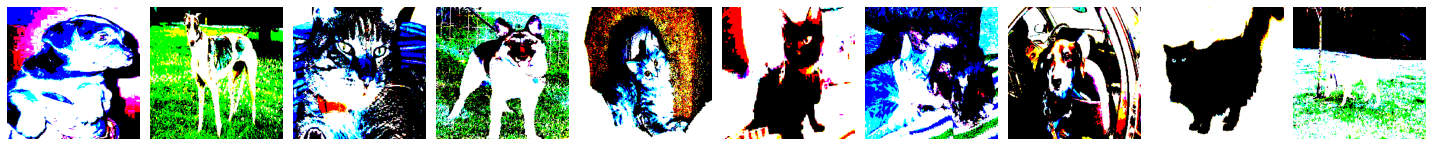

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [29]:
plotImages(imgs)
print(labels)

Podemos ver como las imágenes representan gatos y perros y utilizando one-hot encoding, perros son representados por [0,1] y gatos por [1,0]. 




### Generando el modelo.

Ahora, a introducir el modelo y entrenarlo:

In [30]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])


In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 2)                 4

Y ahora compilamos el modelo: utilizamos el optimizador Adam con una curva de aprendizaje de 0.0001, utilizamos categorical crossentropy para minimizar la pérdida del modelo y tomamos accuracy (exactitud) como la métrica de la performance del modelo. 
  Si bien podríamos utilizar binary crossentropy en vez de categorical, eso nos obligaría a cambiar la función de activación del modelo de softmax a sigmoid. 

In [32]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Ahora si, a entrenar el modelo:

In [33]:
model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose=2
)

Epoch 1/10
100/100 - 82s - loss: 19.6702 - accuracy: 0.5780 - val_loss: 4.7214 - val_accuracy: 0.5550 - 82s/epoch - 824ms/step
Epoch 2/10
100/100 - 82s - loss: 2.6348 - accuracy: 0.7470 - val_loss: 2.7720 - val_accuracy: 0.6100 - 82s/epoch - 820ms/step
Epoch 3/10
100/100 - 82s - loss: 0.4333 - accuracy: 0.8960 - val_loss: 2.4608 - val_accuracy: 0.6100 - 82s/epoch - 817ms/step
Epoch 4/10
100/100 - 82s - loss: 0.1032 - accuracy: 0.9700 - val_loss: 2.4472 - val_accuracy: 0.6150 - 82s/epoch - 817ms/step
Epoch 5/10
100/100 - 81s - loss: 0.0306 - accuracy: 0.9880 - val_loss: 2.4618 - val_accuracy: 0.6350 - 81s/epoch - 807ms/step
Epoch 6/10
100/100 - 82s - loss: 0.0110 - accuracy: 0.9960 - val_loss: 2.2818 - val_accuracy: 0.6500 - 82s/epoch - 817ms/step
Epoch 7/10
100/100 - 80s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 2.1626 - val_accuracy: 0.6450 - 80s/epoch - 801ms/step
Epoch 8/10
100/100 - 80s - loss: 7.6006e-04 - accuracy: 1.0000 - val_loss: 2.1777 - val_accuracy: 0.6400 - 80s/epoch 

Nuestro modelo llegó a un 100% de exactitud en menos de 10 épocas, lo cual es muy bueno, pero comparando con la data de validación vemos que tiene un claro problema de overfitting a nuestra data de entrenamiento. Esto se puede arreglar disminuyendo las épocas , entre otras cosas. También podemos utilizar un modelo pre-entrenado para esta data.

### Probando el modelo con test data

Llamamos a nuestro batch de test data e incluso podemos plotear como se ve: 

In [34]:
test_imgs, test_labels = next(test_batches)

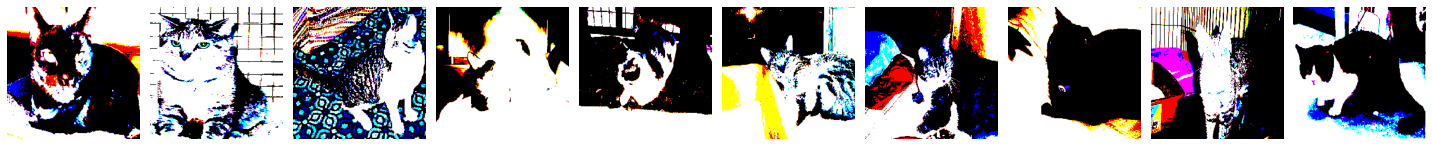

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [35]:
plotImages(test_imgs)
print(test_labels)

En esta tanda podemos ver como todas estas imágenes son de gatos. Esto es porque elegimos no mezclar nuestra data para lograr crear una matriz de confusión más adelante. 

Entonces ahora podemos llamar a nuestro modelo para predecir sobre nuestra data. 

In [36]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [ ]:
np.round(predictions)

Con las etiquetas que nuestro modelo predijo ahora podemos armar una matriz de confusión para poder visualizar la exactitud del modelo.

In [38]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [41]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[38 12]
 [20 30]]


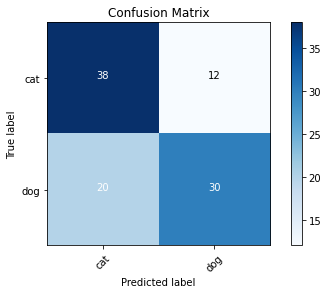

In [42]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

Aquí podemos ver el resultado del overfitting de nuestro modelo, que predijo que para gatos 38 eran efectivamente gatos pero que 20 eran perros, y que para perros, que 30 eran efectivamente perros mientras que 12 eran gatos. 

Para ser un modelo muy sencillo es relativamente efectivo, pero utilizar un modelo pre-entrenado puede llevar a mejores resultados con tan solo modificar un poco sus parámetros. 